# Testing different Regression methods

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

## Generalized function for Regression testing

In [39]:
def LR_coef_test(model, df, SPLIT_YEAR, out=True):
    if SPLIT_YEAR:
        df_filt_train = df[df['YEAR'] <= SPLIT_YEAR]
        df_filt_test = df[df['YEAR'] > SPLIT_YEAR]
    else:
        df_filt_train = df.copy()
        df_filt_test = df.copy()

    X_train = df_filt_train.drop(columns=["MEDIAN HOUSING PRICE"])
    Y_train = df_filt_train["MEDIAN HOUSING PRICE"]
    X_test = df_filt_test.drop(columns=["MEDIAN HOUSING PRICE"])
    Y_test = df_filt_test["MEDIAN HOUSING PRICE"]

    LR_model = model
    LR_model.fit(X_train, Y_train)

    y_pred = LR_model.predict(X_test)
    mse = mean_squared_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)

    # check if pipeline
    try:
        coefs = LR_model.coef_
    except AttributeError:
        coefs = LR_model.named_steps[list(LR_model.named_steps.keys())[-1]].coef_

    # check if polynomial
    try:
        feature_names = LR_model.named_steps['polynomialfeatures'].get_feature_names_out(X_test.columns)
    except (KeyError, AttributeError):
        feature_names = X_test.columns

    coef_label = pd.DataFrame({
        'Feats': feature_names,
        'Coefs': coefs
    })

    if out:
        print(f"\n=========== {str(LR_model)} ===========")
        print(coef_label.sort_values(by='Coefs'))
        print(f'Mean Squared Error: {mse:.2f}, Sqrt MSE: {np.sqrt(mse):.2f}')
        print(f'R^2 Score: {r2:.2f}\n\n')

    return (coef_label, mse, r2)

In [40]:
def addRes(df, model_name, mse, r2):
    row = pd.DataFrame({'Model': [model_name], 'MSE': [mse], 'R2': [r2]})
    return pd.concat([df, row], ignore_index=True)


## Pipeline imports and hyperparam(s)

In [41]:
from sklearn.linear_model import RidgeCV, LassoCV, HuberRegressor, LinearRegression, SGDRegressor, ElasticNetCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

df = pd.read_csv('Data/edited data/merged_data.csv')
df = df.astype(float)

# Hyperparams:
DEG = 1
SPLIT_YEAR = 2018


## Try out different models

In [42]:
df_res = pd.DataFrame(columns=['Model', 'MSE', 'R2'])

#### OLS

In [43]:
model = make_pipeline(StandardScaler(), 
                      PolynomialFeatures(degree=DEG, include_bias=False),
                      LinearRegression()
                      )

(_, mse, r2) = LR_coef_test(model, df, SPLIT_YEAR)
df_res = addRes(df_res, 'OLS', mse, r2)


=========== Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=1, include_bias=False)),
                ('linearregression', LinearRegression())]) ===========
                                      Feats         Coefs
15                      PRIME INTEREST RATE -56496.248025
8                      University degree 13 -33697.869530
1                                    GDMPBC -22297.513917
7   Postsecondary certificate or diploma 12 -16086.050925
6                     Some postsecondary 11  -2949.673723
3                           0 to 8  years 8  -1756.223367
13                                  QUARTER   -640.185164
16                        QUARTERLY PAYMENT    575.164733
18                        NUMBER OF RESALES   3375.553318
4                        Some high school 9   6111.373897
10                  Above bachelor's degree   7792.016082
12                    Annual Percent Change   7891.643287
5

C:\Users\money\AppData\Local\Temp\ipykernel_25200\3675724848.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, row], ignore_index=True)


#### RidgeCV: L2 regularization w/ CV

In [44]:
model = make_pipeline(StandardScaler(), 
                      PolynomialFeatures(degree=DEG, include_bias=False),
                      RidgeCV(cv=5)
                      )

(_, mse, r2) = LR_coef_test(model, df, SPLIT_YEAR)
df_res = addRes(df_res, 'RidgeCV', mse, r2)


=========== Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=1, include_bias=False)),
                ('ridgecv', RidgeCV(cv=5))]) ===========
                                      Feats         Coefs
15                      PRIME INTEREST RATE -18641.915665
9                         Bachelor's degree  -5627.052779
8                      University degree 13  -4246.439062
6                     Some postsecondary 11   -893.782370
13                                  QUARTER   -126.427714
2               Total, all education levels    826.346633
12                    Annual Percent Change   2359.941921
3                           0 to 8  years 8   3354.611366
10                  Above bachelor's degree   4380.752064
17                PAYMENT TO INCOME PERCENT   5572.550963
5                   High school graduate 10   5846.199344
4                        Some high school 9   6522.720996
18             

#### LassoCV: L1 regularization & "feature selection" w/ CV

In [45]:
model = make_pipeline(StandardScaler(), 
                    PolynomialFeatures(degree=DEG, include_bias=False),
                    LassoCV(cv=5, 
                    alphas=np.logspace(-5, 0, 100), # 100 values of alpha in log scale
                    max_iter=100000)
                    ) 

(_, mse, r2) = LR_coef_test(model, df, SPLIT_YEAR)
df_res = addRes(df_res, 'LassoCV', mse, r2)


=========== Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=1, include_bias=False)),
                ('lassocv',
                 LassoCV(alphas=array([1.00000000e-05, 1.12332403e-05, 1.26185688e-05, 1.41747416e-05,
       1.59228279e-05, 1.78864953e-05, 2.00923300e-05, 2.25701972e-05,
       2.53536449e-05, 2.84803587e-05, 3.19926714e-05, 3.59381366e-05,
       4.03701726e-05...
       6.89261210e-02, 7.74263683e-02, 8.69749003e-02, 9.77009957e-02,
       1.09749877e-01, 1.23284674e-01, 1.38488637e-01, 1.55567614e-01,
       1.74752840e-01, 1.96304065e-01, 2.20513074e-01, 2.47707636e-01,
       2.78255940e-01, 3.12571585e-01, 3.51119173e-01, 3.94420606e-01,
       4.43062146e-01, 4.97702356e-01, 5.59081018e-01, 6.28029144e-01,
       7.05480231e-01, 7.92482898e-01, 8.90215085e-01, 1.00000000e+00]),
                         cv=5, max_iter=100000))]) ===========
                                     

#### Huber: OLS with robustness to outliers

In [46]:
# lower epsilon = more robust (performed best), alpha was fine tuned manually
model = make_pipeline(StandardScaler(), 
                      PolynomialFeatures(degree=DEG, include_bias=False),
                      HuberRegressor(max_iter=100000, alpha=1e-7, epsilon=1) 
                      ) 

(_, mse, r2) = LR_coef_test(model, df, SPLIT_YEAR)
df_res = addRes(df_res, 'Huber', mse, r2)


=========== Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=1, include_bias=False)),
                ('huberregressor',
                 HuberRegressor(alpha=1e-07, epsilon=1, max_iter=100000))]) ===========
                                      Feats         Coefs
15                      PRIME INTEREST RATE -52921.575075
1                                    GDMPBC -15064.328756
7   Postsecondary certificate or diploma 12  -9794.606835
9                         Bachelor's degree  -7517.327641
8                      University degree 13  -2684.774999
0                                      YEAR  -1823.406127
16                        QUARTERLY PAYMENT  -1772.626885
13                                  QUARTER   -373.307774
6                     Some postsecondary 11   -366.411562
10                  Above bachelor's degree    551.720216
3                           0 to 8  years 8    842.418074
18     

#### SGDRegressor

In [47]:
best_score = [0,0]

for i in range(1000):
    model = make_pipeline(
        StandardScaler(), 
        PolynomialFeatures(degree=DEG, include_bias=False),
        SGDRegressor(penalty='l2', max_iter=100000000, alpha=0.001, early_stopping=True)
    )
    coefs, mse, r2 = LR_coef_test(model, df, SPLIT_YEAR, False)
    if best_score[1] < r2:
        best_score[0] = mse
        best_score[1] = r2
        print(f"[{i}]: {r2}")

print(f"\n=========== {str(model)} ===========")
print(coefs.sort_values(by='Coefs'))
print(f'Mean Squared Error: {best_score[0]:.2f}, Sqrt MSE: {best_score[0]:.2f}')
print(f'R^2 Score: {best_score[1]:.2f}\n\n')

df_res = addRes(df_res, 'SGD', best_score[0], best_score[1])

[0]: 0.6953146605296461
[11]: 0.755659413348181
[58]: 0.762314774725552
[616]: 0.7716050338469804

=========== Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=1, include_bias=False)),
                ('sgdregressor',
                 SGDRegressor(alpha=0.001, early_stopping=True,
                              max_iter=100000000))]) ===========
                                      Feats         Coefs
15                      PRIME INTEREST RATE -16580.209977
9                         Bachelor's degree  -5226.139422
8                      University degree 13  -3819.844429
13                                  QUARTER  -1432.987122
6                     Some postsecondary 11   -840.981571
2               Total, all education levels   1716.413743
12                    Annual Percent Change   1890.558405
10                  Above bachelor's degree   4143.081669
5                   High school graduate 10 

#### ElasticNet: L1 and L2 w/ CV

In [48]:
model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=DEG, include_bias=False),
    ElasticNetCV(cv=5, alphas=np.logspace(-1, 1, 100), max_iter=10000)
)

(_, mse, r2) = LR_coef_test(model, df, SPLIT_YEAR)
df_res = addRes(df_res, 'ElasticNet', mse, r2)


=========== Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=1, include_bias=False)),
                ('elasticnetcv',
                 ElasticNetCV(alphas=array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.2205...
        2.05651231,  2.15443469,  2.25701972,  2.36448941,  2.47707636,
        2.59502421,  2.71858824,  2.84803587,  2.98364724,  3.12571585,
        3.27454916,  3.43046929,  3.59381366,  3.76493581,  3.94420606,
        4.1320124 ,  4.32876128,  4.53487851,  4.75081016,  4.97702356,
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.  

# Plot Results

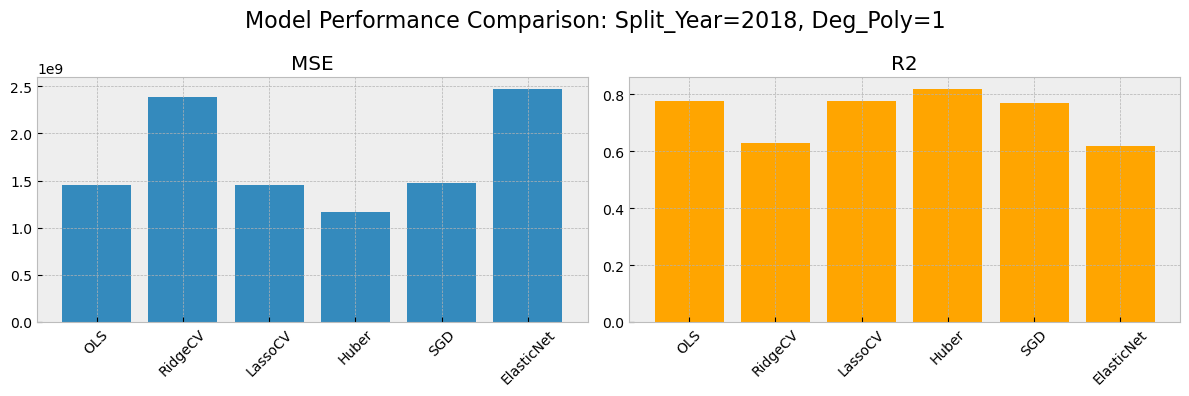

In [49]:
plt.style.use("bmh")
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

fig.suptitle(f"Model Performance Comparison: Split_Year={SPLIT_YEAR}, Deg_Poly={DEG}", fontsize=16)

ax[0].bar(df_res['Model'], df_res['MSE'])
ax[0].set_title("MSE")
ax[0].tick_params(axis='x', rotation=45)

ax[1].bar(df_res['Model'], df_res['R2'], color='orange')
ax[1].set_title("R2")
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f"Output/LRC-{SPLIT_YEAR}-{DEG}")
plt.show()